# Determine rate of RNA export by Gag-MCP

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_export_rate"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
# Summary of replicates

infile = "../preprocessed_data/qPCR_data/qPCR_export_rate_Cq_summary.csv"

cq_summary = pd.read_csv(infile, index_col="id")

print(cq_summary.shape)
cq_summary.head()

(7, 20)


,Well,Content,Sample,Transfected,Time,color,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,num_live_cells,cells_per_mL,percent_live,live_cells_per_mL,time_actual,legend_label,SQ_Mean_censored
id,,,,,,,,,,,,,,,,,,,,
GagMCP_mCh-MSx8_0h,A01,Unkn-01,Well 1,GagMCP_mCh-MS2x8,0,#756bb1,29.326022,29.264014,0.167171,1.278475e+04,4.106692,1.340740e+04,1593.949590,924000,4770000.0,97.0,4620000.0,0.00,Gag-MCP,1.891543e+04
GagMCP_mCh-MSx8_18h,A02,Unkn-02,Well 2,GagMCP_mCh-MS2x8,18,#756bb1,21.052686,21.051167,0.122507,3.964571e+06,6.598196,3.978308e+06,337914.409200,1100000,5670000.0,97.0,5500000.0,18.16,Gag-MCP,3.978308e+06
GagMCP_mCh-MSx8_24h,A03,Unkn-03,Well 3,GagMCP_mCh-MS2x8,24,#756bb1,20.654939,20.538907,0.131136,5.223690e+06,6.717977,5.677105e+06,522393.330200,1340000,6920000.0,97.0,6700000.0,24.00,Gag-MCP,5.677105e+06
mCh-MSx8_0h,A05,Unkn-05,Well 5,mCh-MS2x8,0,#969696,33.900609,34.941332,1.210660,5.358723e+02,2.729061,3.191550e+02,216.119517,1032000,5270000.0,98.0,5160000.0,0.00,No Exporter,1.891543e+04
mCh-MSx8_18h,A06,Unkn-06,Well 6,mCh-MS2x8,18,#969696,28.480392,30.711770,2.188982,2.298013e+04,4.361352,9.563056e+03,11750.362920,1300000,6710000.0,97.0,6500000.0,18.16,No Exporter,1.891543e+04


In [5]:
# Replicates

infile = "../preprocessed_data/qPCR_data/qPCR_export_rate_Cq.csv"

cq_raw = pd.read_csv(infile)

cq_raw = cq_raw.set_index("id")

print(cq_raw.shape)
cq_raw.head()

(45, 13)


,Well,Content,Sample,Transfected,Time,color,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
id,,,,,,,,,,,,,
GagMCP_mCh-MSx8_0h,A01,Unkn-01,Well 1,GagMCP_mCh-MS2x8,0.0,#756bb1,29.326022,29.264014,0.167171,1.278475e+04,4.106692,1.340740e+04,1593.949590
GagMCP_mCh-MSx8_18h,A02,Unkn-02,Well 2,GagMCP_mCh-MS2x8,18.0,#756bb1,21.052686,21.051167,0.122507,3.964571e+06,6.598196,3.978308e+06,337914.409200
GagMCP_mCh-MSx8_24h,A03,Unkn-03,Well 3,GagMCP_mCh-MS2x8,24.0,#756bb1,20.654939,20.538907,0.131136,5.223690e+06,6.717977,5.677105e+06,522393.330200
mCh-MSx8_0h,A05,Unkn-05,Well 5,mCh-MS2x8,0.0,#969696,33.900609,34.941332,1.210660,5.358723e+02,2.729061,3.191550e+02,216.119517
mCh-MSx8_18h,A06,Unkn-06,Well 6,mCh-MS2x8,18.0,#969696,28.480392,30.711770,2.188982,2.298013e+04,4.361352,9.563056e+03,11750.362920


# Preprocess data

## Calculate total starting molecules

Note that an mRNA standard curve was used here.

To explain further, to create the standard curve, we produced mRNA of mCherry by in vitro transcription, then processed it through the standard RT-qPCR pipeline, which consists of RNA extraction, DNase treatment, reverse transcription, and qPCR. Thus, the quantification of samples by qPCR against this standard curve is already
calibrated to number of RNA molecules.

Therefore, to calculate total starting molecules, we only need to calculate the dilution factors associated with processing.

In [6]:
# Calculate normalization for input volume

FRACTION_OF_SUPERNATANT_SAMPLED = (140/1000) * (20/60) * (10/61) * (1/20)  # Fraction of total supernatant volume that was input to qPCR

print("Fraction of supernatant sampled:", FRACTION_OF_SUPERNATANT_SAMPLED)

Fraction of supernatant sampled: 0.0003825136612021858


In [7]:
cq_summary["num_molecules"] = cq_summary["SQ Mean"] * (1/FRACTION_OF_SUPERNATANT_SAMPLED)
cq_summary["num_molecules_std"] = cq_summary["SQ Std. Dev"] * (1/FRACTION_OF_SUPERNATANT_SAMPLED)
# cq_summary["num_molecules_censored"] = cq_summary["SQ_Mean_censored"] * (1/FRACTION_OF_SUPERNATANT_SAMPLED)

cq_raw["num_molecules"] = cq_raw["Starting Quantity (SQ)"] * (1/FRACTION_OF_SUPERNATANT_SAMPLED)
# cq_raw["num_molecules_std"] = cq_raw["SQ Std. Dev"] * (1/FRACTION_OF_SUPERNATANT_SAMPLED)

## Determine lower limit of quantification (using blank)

In [8]:
DETECTION_LIMIT = cq_summary.loc["Blank", "num_molecules"]

print(DETECTION_LIMIT, "molecules")

49450345.12114286 molecules


## Censor by lower limit of quantification

In [9]:
cq_summary["num_molecules_censored"] = cq_summary["num_molecules"]
cq_summary.loc[cq_summary["num_molecules"] < DETECTION_LIMIT, "num_molecules_censored"] = DETECTION_LIMIT

cq_raw["num_molecules_censored"] = cq_raw["num_molecules"]
cq_raw.loc[cq_raw["num_molecules"] < DETECTION_LIMIT, "num_molecules_censored"] = DETECTION_LIMIT

## Calculate number of transfected cells

In [10]:
FRACTION_CELLS_GFP_MCH_POSITIVE = 0.53  # fraction of GFP+ mCh+ cells assessed by flow cytometry
cq_summary["num_live_cells_transfected"] = cq_summary["num_live_cells"] * FRACTION_CELLS_GFP_MCH_POSITIVE

# Fit model to extract rate

In [11]:
# Fit model to accumulation of molecules over time
selector = (cq_raw["Time"].isin([0, 18, 24])) & (cq_raw["Transfected"] == "GagMCP_mCh-MS2x8")
data_subset = cq_raw.loc[selector]

x = data_subset["Time"]
y = data_subset["num_molecules_censored"]

coef, cov = np.polyfit(x, y, 1, cov=True)

print("Slope:", coef[0])
print("Intercept:", coef[1])
print("Slope STD:", np.sqrt(cov[0,0]))

Slope: 606811418.2462124
Intercept: -64874142.578022
Slope STD: 31034435.666818313


In [12]:
# To get number of cells, use actual cell count to calculate mean number of cells over window
id_initial = "GagMCP_mCh-MSx8_0h"
id_final = "GagMCP_mCh-MSx8_24h"
n_cells_initial = cq_summary.loc[id_initial, "num_live_cells_transfected"]
n_cells_final = cq_summary.loc[id_final, "num_live_cells_transfected"]
n_cells_mean = (n_cells_final + n_cells_initial)/2

print("Cells initial", n_cells_initial)
print("Cells final", n_cells_final)
print("Cells mean", n_cells_mean)

Cells initial 489720.0
Cells final 710200.0
Cells mean 599960.0


In [13]:
# Calculate export rate per cell
k_export = coef[0] / n_cells_mean
k_export_std = np.sqrt(cov[0,0]) / n_cells_mean  # standard deviation based on variance of fit

print("Export rate:", k_export, "molecules/cell-hr")
print("Export rate STD:", k_export_std, "molecules/cell-hr")

Export rate: 1011.4197917298026 molecules/cell-hr
Export rate STD: 51.72750794522687 molecules/cell-hr


# Plot accumulated molecules against time with fitted model

In [14]:
palette = ["#756bb1", "#969696"]

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


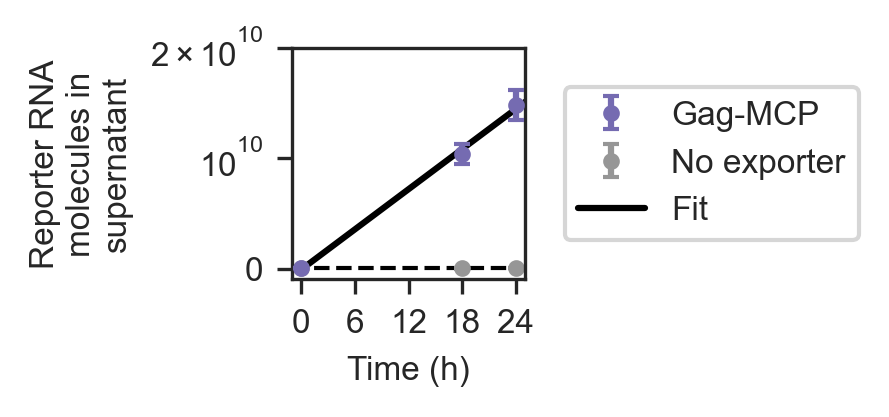

In [15]:
selector = (cq_summary["Time"].isin([0, 18, 24]))
data = cq_summary.loc[selector]

fig, ax = plt.subplots(1, 1, figsize=(1, 1))

data_subset = data.loc[data["Transfected"] == "GagMCP_mCh-MS2x8"]
ax.errorbar(x=data_subset["Time"], y=data_subset["num_molecules_censored"],
            yerr=data_subset["num_molecules_std"],
            color=palette[0],
            marker="o", markersize=3,
            capsize=2, ls="", zorder=3,
            label="Gag-MCP")

# Plot fit
x = data_subset["Time"]
y = data_subset["num_molecules_censored"]
coef = np.polyfit(x, y, 1)
fit = np.poly1d(coef)
x_fitted = np.arange(0, 30)
y_fitted = fit(x_fitted)
ax.plot(x_fitted,
        y_fitted,
        marker=None,
        color="k",
        zorder=1,
        label="Fit")

data_subset = data.loc[data["Transfected"] == "mCh-MS2x8"]
ax.errorbar(x=data_subset["Time"], y=data_subset["num_molecules_censored"],
            yerr=data_subset["num_molecules_std"],
            color=palette[1],
            marker="o", markersize=3,
            capsize=2, ls="", zorder=2,
            label="No exporter")

ax.set_xlim(-1, 25)

ax.set_xticks([0, 6, 12, 18, 24])
ax.set_yticks([0, 1e10, 2e10])

yticklabels = ["0", r"$10^{10}$", r"$2 \times 10^{10}$"]
ax.set_yticklabels(yticklabels)

ax.set_xlabel("Time (h)")
ax.set_ylabel("Reporter RNA\nmolecules in\nsupernatant")

ax.axhline(y=DETECTION_LIMIT, linestyle="--", color="k", lw=1, zorder=0)

# adjust legend order
order = [1, 2, 0]
handles, labels = ax.get_legend_handles_labels()
handles_ordered = [handles[idx] for idx in order]
labels_ordered = [labels[idx] for idx in order]
plt.legend(handles_ordered, labels_ordered, loc="center left", bbox_to_anchor=(1.1, 0.5))

save_figure(fig, "scatter_fit")